<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/11_cnn_pytorch/07_single_shot_multibox_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Shot Mutibox Detector (SSD)


---


物体検出タスクで主流となっているSSDについて説明します．

## 概要
SSDは，物体候補領域の検出とクラス分類を単一のネットワークで行うモデルです．SSDのネットワーク構造は，複数の畳み込み層から物体矩形と物体クラスのスコアを出力させることで，スケール変化に頑健な物体検出ができます．6つの予測レイヤでは，アスペクト比が固定されたデフォルトボックスと呼ばれる矩形を使って複数の物体候補領域を検出します．複数のアスペクト比のデフォルトボックスを使うことで，様々な形状の物体に対応可能です．予測レイヤで得られるボックスのオフセットを表す特徴マップ(Localization maps)を用いて，すべてのデフォルトボックスをより物体に近い形状に回帰します．また，同様に予測レイヤで得られる物体のクラス尤度を表す特徴マップ(Confidence maps)を用いて，物体のクラスを識別します．

<img src="https://drive.google.com/uc?export=view&id=1SQ9dxoquNvEogdK5RPS70mtiAq_2poO5" width = 100%>

<img src="https://drive.google.com/uc?export=view&id=1Ldml8X0BqwDjYahr2IXpEc71ofHQ3nP9" width = 40%>



### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**

## データのダウンロード
まず，学習を行うデータセットをダウンロードします．ここでは，物体検出タスクの性能評価に用いられるARC2017 RGB-Dデータセットを使用します．ARC2017 RGB-Dは2017年にAmazon Robotics Challengeにて使用された全40クラスを収録する物体検出のデータセットです．
ARC2017 RGB-Dデータセットの詳細については以下サイトを参照してください．
http://mprg.jp/research/arc_dataset_2017_j

In [1]:
# データセットのダウンロード
!wget http://www.mprg.cs.chubu.ac.jp/ARC2017/ARCdataset_png.zip 
!unzip -q ARCdataset_png.zip 

--2021-01-14 17:49:51--  http://www.mprg.cs.chubu.ac.jp/ARC2017/ARCdataset_png.zip
Resolving www.mprg.cs.chubu.ac.jp (www.mprg.cs.chubu.ac.jp)... 157.110.42.95
Connecting to www.mprg.cs.chubu.ac.jp (www.mprg.cs.chubu.ac.jp)|157.110.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3646315785 (3.4G) [application/zip]
Saving to: ‘ARCdataset_png.zip’

ARCdataset_png.zip  100%[===================>]   3.40G  10.1MB/s    in 5m 45s  

2021-01-14 17:55:36 (10.1 MB/s) - ‘ARCdataset_png.zip’ saved [3646315785/3646315785]



実験に使用するソフトウェア一式をダウンロードします．

In [2]:
# ソフトウェアのダウンロード
!wget http://www.mprg.cs.chubu.ac.jp/MPRG_Seminar2020/07_SSD.zip 
!unzip -q 07_SSD.zip 

!ls

--2021-01-14 18:01:38--  http://www.mprg.cs.chubu.ac.jp/MPRG_Seminar2020/07_SSD.zip
Resolving www.mprg.cs.chubu.ac.jp (www.mprg.cs.chubu.ac.jp)... 157.110.42.95
Connecting to www.mprg.cs.chubu.ac.jp (www.mprg.cs.chubu.ac.jp)|157.110.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107663397 (103M) [application/zip]
Saving to: ‘07_SSD.zip’

07_SSD.zip          100%[===================>] 102.68M  10.2MB/s    in 11s     

2021-01-14 18:01:50 (9.07 MB/s) - ‘07_SSD.zip’ saved [107663397/107663397]

07_SSD	07_SSD.zip  ARCdataset_png  ARCdataset_png.zip	sample_data


ダウンロードしたソフトウェアの中身を確認します．
フォルダ07_SSDには以下のファイルが内包されています． \\
- SSD_pretrained.pth ← 学習済みモデル \\
- detect_evaluation ← 評価用ソフトウェア \\

作業ディレクトリを先程ダウンロードしたフォルダに移動します．

In [3]:
# 作業ディレクトリの移動
%cd 07_SSD
!ls

/content/07_SSD
detect_evaluation  SSD_pretrained.pth


## モジュールのインポート
プログラムを実行するために必要なモジュールをインポートします．
本実験では，facebookが開発した機械学習ライブラリのPyTorchを使用します．

In [36]:
import cv2 as cv    # 画像処理
import numpy as np  # 計算
import torch        # 機械学習ライブラリ
import torchsummary # ネットワーク情報表示

実験はGPUを使用するので，colaboratory上で使用可能な状態か確認します．

In [37]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print('device:{}'.format(device))

device:cuda


In [6]:
!nvidia-smi

Thu Jan 14 18:06:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

最初に，評価する画像が入ったフォルダやネットワークのハイパーパラメータを定義します．後に作成するネットワーク定義やテストプログラムからも，値を参照できるようにしておきます．

In [38]:
class common:
  def __init__(self):
      # 学習画像のディレクトリ
    self.images_dir = "/root/home/data/ARCdataset_png"

    # 学習モデル,ロス値の保存ディレクトリ ※頻繁にアクセスがあるのでオンラインストレージ領域にしない
    self.save_model_dir = "/root/home/data/ARCdataset"

    # SSDの入力画像サイズ
    self.insize = 300

    # 識別のクラス数 (背景込み)
    self.num_of_classes = 41
    #ARC:41, VOC:21

    # Bounding boxのオフセットベクトルの次元数
    self.num_of_offset_dims = 4

    # Bounding boxのオフセットとクラスを推定する畳み込み層
    self.mbox_source_layers = ['conv9_2', 'preconv3_conv8_2', 'esconv2', 'esconv3', 'esconv4', 'esconv5']

    # Default boxの最小・最大比率 (in percent %)
    self.min_ratio = 20
    self.max_ratio = 90

    # 各階層における特徴マップの入力画像上のステップ幅
    self.steps = [8, 16, 32, 64, 100, 300]

    # 各階層のdefault boxの数
    self.num_boxes = [4, 6, 6, 6, 4, 4]

    # 各階層の特徴マップのDefault boxのアスペクト比
    self.aspect_ratios = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]

    # 各階層の特徴マップの解像度
    self.map_sizes = [38, 19, 10, 5, 3, 1]

    self.loc_var = 0.01

    # Data Augmentationで増加させる倍数
    self.augmentation_factor = 30
    #ARC:30倍，VOC:15倍

    # Data Augmentationのパラメータ
    self.jitter = 0.3      # Default : 0.2
    self.saturation = 1.5  # Default : 1.5
    self.exposure = 1.5    # Default : 1.5
    self.hue = 0.03        # Default : 0.03

    # choose border type
    # BORDER_REPLICATE, BORDER_REFLECT, BORDER_REFLECT_101, BORDER_WRAP, BORDER_CONSTANT
    self.border_type = cv.BORDER_CONSTANT

    #border_val = (36, 36, 71)
    self.border_val = (127, 127, 127)
    #border_val = (0, 0, 0)

    # optimizer (MomentumSGDの学習パラメータ)
    self.learning_rate = 10e-3
    self.momentum = 0.9
    self.weight_decay = 0.0005

    self.lr_step = 0.97
    self.lr_change_epoch = 80
    self.lower_lr = 10e-4

    # ARCクラスラベル (クラス名にはスペース(空白)は禁止)
    self.arc_labels = [
          "Background",             #0
          "Binder",                 #1
          "Balloons",               #2
          "Baby_Wipes",             #3
          "Toilet_Brush",           #4
          "Toothbrushes",           #5
          "Crayons",                #6
          "Salts",                  #7
          "DVD",                    #8
          "Glue_Sticks",            #9
          "Eraser",                 #10
          "Scissors",               #11
          "Green_Book",             #12
          "Socks",                  #13
          "Irish_Spring",           #14
          "Paper_Tape",             #15
          "Touch_Tissues",          #16
          "Knit_Gloves",            #17
          "Laugh_Out_Loud_Jokes",   #18
          "Pencil_Cup",             #19
          "Mini_Marbles",           #20
          "Neoprene_Weight",        #21
          "Wine_Glasses",           #22
          "Water_Bottle",           #23
          "Reynolds_Pie",           #24
          "Reynolds_Wrap",          #25
          "Robots_Everywhere",      #26
          "Duct_Tape",              #27
          "Sponges",                #28
          "Speed_Stick",            #29
          "Index_Cards",            #30
          "Ice_Cube_Tray",          #31
          "Table_Cover",            #32
          "Measuring_Spoons",       #33
          "Bath_Sponge",            #34
          "Pencils",                #35
          "Mousetraps",             #36
          "Face_Cloth",             #37
          "Tennis_Balls",           #38
          "Spray_Bottle",           #39
          "Flashlights"]            #40

    # クラスの色
    self.arc_class_color = np.array([
               [  0,   0,   0],
               [ 85,   0,   0],
               [170,   0,   0],
               [255,   0,   0],
               [  0,  85,   0],
               [ 85,  85,   0],
               [170,  85,   0],
               [255,  85,   0],
               [  0, 170,   0],
               [ 85, 170,   0],
               [170, 170,   0],
               [255, 170,   0],
               [  0, 255,   0],
               [ 85, 255,   0],
               [170, 255,   0],
               [255, 255,   0],
               [  0,   0,  85],
               [ 85,   0,  85],
               [170,   0,  85],
               [255,   0,  85],
               [  0,  85,  85],
               [ 85,  85,  85],
               [170,  85,  85],
               [255,  85,  85],
               [  0, 170,  85],
               [ 85, 170,  85],
               [170, 170,  85],
               [255, 170,  85],
               [  0, 255,  85],
               [ 85, 255,  85],
               [170, 255,  85],
               [255, 255,  85],
               [  0,   0, 170],
               [ 85,   0, 170],
               [170,   0, 170],
               [255,   0, 170],
               [  0,  85, 170],
               [ 85,  85, 170],
               [170,  85, 170],
               [255,  85, 170],
               [  0, 170, 170]])

common_params = common()

## ネットワークの定義
次に，SSDのネットワークを定義します．SSDは入力サイズが300x300のSSD300と512x512のSSD512があります．SSD512の方が入力サイズが大きいため，基本的には検出精度は向上しますが処理に時間がかかります．今回の実験では，入力サイズの小さいSSD300を用います．

In [39]:
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F


class Flatten(nn.Module):  # Tensor [:, :, :, :] -> [:]
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)


class L2Normalization(nn.Module):
    def __init__(self, channels, gamma=20):
        super().__init__()
        self.gamma = gamma
        self.in_channels = channels
        self.out_channels = channels
        self.scales = nn.Parameter(torch.Tensor(self.in_channels))  # trainable
        self.reset_parameters()

    def reset_parameters(self):
        init.constant_(self.scales, self.gamma)  # initialized with gamma first

    # Note that pytorch's dimension order is batch_size, channels, height, width
    def forward(self, x):
        # |x|_2
        # normalize (x^)
        x = F.normalize(x, p=2, dim=1)
        return self.scales.unsqueeze(0).unsqueeze(2).unsqueeze(3) * x


class SSDNet(nn.Module):

    def __init__(self):
        super(SSDNet, self).__init__()
        # feature layers
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        self.relu1_2 = nn.ReLU(inplace=True)

        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1)
        self.relu2_2 = nn.ReLU(inplace=True)

        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1)
        self.relu3_3 = nn.ReLU(inplace=True)

        self.maxpool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, ceil_mode = True)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu4_3 = nn.ReLU(inplace=True)

        self.l2norm4_3 = L2Normalization(channels=512, gamma=20)

        self.maxpool4 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1)
        self.relu5_3 = nn.ReLU(inplace=True)

        self.maxpool5 = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)

        self.conv6 = nn.Conv2d(512, 1024, kernel_size = 3, stride = 1, padding = 6, dilation=6)
        self.relu6 = nn.ReLU(inplace=True)
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size = 1, stride = 1, padding = 0)
        self.relu7 = nn.ReLU(inplace=True)

        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.relu8_1 = nn.ReLU(inplace=True)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.relu8_2 = nn.ReLU(inplace=True)

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, stride=1, padding=0)
        self.relu9_1 = nn.ReLU(inplace=True)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.relu9_2 = nn.ReLU(inplace=True)

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0)
        self.relu10_1 = nn.ReLU(inplace=True)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.relu10_2 = nn.ReLU(inplace=True)

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0)
        self.relu11_1 = nn.ReLU(inplace=True)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0)
        self.relu11_2 = nn.ReLU(inplace=True)

        # localization layers
        self.conv4_3_loc = nn.Conv2d(512, common_params.num_of_offset_dims * common_params.num_boxes[0], kernel_size=3, stride=1, padding=1)
        self.conv7_loc = nn.Conv2d(1024, common_params.num_of_offset_dims * common_params.num_boxes[1], kernel_size=3, stride=1, padding=1)
        self.conv8_2_loc = nn.Conv2d(512, common_params.num_of_offset_dims * common_params.num_boxes[2], kernel_size=3, stride=1, padding=1)
        self.conv9_2_loc = nn.Conv2d(256, common_params.num_of_offset_dims * common_params.num_boxes[3], kernel_size=3, stride=1, padding=1)
        self.conv10_2_loc = nn.Conv2d(256, common_params.num_of_offset_dims * common_params.num_boxes[4], kernel_size=3, stride=1, padding=1)
        self.conv11_2_loc = nn.Conv2d(256, common_params.num_of_offset_dims * common_params.num_boxes[5], kernel_size=3, stride=1, padding=1)

        # confidence layers
        self.conv4_3_cls = nn.Conv2d(512, common_params.num_of_classes * common_params.num_boxes[0], kernel_size=3, stride=1, padding=1)
        self.conv7_cls = nn.Conv2d(1024, common_params.num_of_classes * common_params.num_boxes[1], kernel_size=3, stride=1, padding=1)
        self.conv8_2_cls = nn.Conv2d(512, common_params.num_of_classes * common_params.num_boxes[2], kernel_size=3, stride=1, padding=1)
        self.conv9_2_cls = nn.Conv2d(256, common_params.num_of_classes * common_params.num_boxes[3], kernel_size=3, stride=1, padding=1)
        self.conv10_2_cls = nn.Conv2d(256, common_params.num_of_classes * common_params.num_boxes[4], kernel_size=3, stride=1, padding=1)
        self.conv11_2_cls = nn.Conv2d(256, common_params.num_of_classes * common_params.num_boxes[5], kernel_size=3, stride=1, padding=1)

    def forward(self, x, train=False):

        k1 = self.relu1_1(self.conv1_1(x))
        k1 = self.relu1_2(self.conv1_2(k1))

        k1 = self.maxpool1(k1)

        k1 = self.relu2_1(self.conv2_1(k1))
        k1 = self.relu2_2(self.conv2_2(k1))

        k1 = self.maxpool2(k1)

        k1 = self.relu3_1(self.conv3_1(k1))
        k1 = self.relu3_2(self.conv3_2(k1))
        k1 = self.relu3_3(self.conv3_3(k1))

        k1 = self.maxpool3(k1)

        k1 = self.relu4_1(self.conv4_1(k1))
        k1 = self.relu4_2(self.conv4_2(k1))
        k1 = self.relu4_3(self.conv4_3(k1))

        l2_k1 = self.l2norm4_3(k1)
        Loc1 = self.conv4_3_loc(l2_k1)  # Box_Estimator_1
        Cls1 = self.conv4_3_cls(l2_k1)  # Class_Classifier_1

        k2 = self.maxpool4(k1)

        k2 = self.relu5_1(self.conv5_1(k2))
        k2 = self.relu5_2(self.conv5_2(k2))
        k2 = self.relu5_3(self.conv5_3(k2))

        k2 = self.maxpool5(k2)

        k2 = self.relu6(self.conv6(k2))
        k2 = self.relu7(self.conv7(k2))

        Loc2 = self.conv7_loc(k2)  # Box_Estimator_2
        Cls2 = self.conv7_cls(k2)  # Class_Classifier_2

        k3 = self.relu8_1(self.conv8_1(k2))
        k3 = self.relu8_2(self.conv8_2(k3))

        Loc3 = self.conv8_2_loc(k3)  # Box_Estimator_3
        Cls3 = self.conv8_2_cls(k3)  # Class_Classifier_3

        k4 = self.relu9_1(self.conv9_1(k3))
        k4 = self.relu9_2(self.conv9_2(k4))

        Loc4 = self.conv9_2_loc(k4)  # Box_Estimator_4
        Cls4 = self.conv9_2_cls(k4)  # Class_Classifier_4

        k5 = self.relu10_1(self.conv10_1(k4))
        k5 = self.relu10_2(self.conv10_2(k5))

        Loc5 = self.conv10_2_loc(k5)  # Box_Estimator_5
        Cls5 = self.conv10_2_cls(k5)  # Class_Classifier_5

        k6 = self.relu11_1(self.conv11_1(k5))
        k6 = self.relu11_2(self.conv11_2(k6))

        Loc6 = self.conv11_2_loc(k6)  # Box_Estimator_6
        Cls6 = self.conv11_2_cls(k6)  # Class_Classifier_6

        if train:
            # (バッチ数,チャンネル数,高さ,幅) -> (バッチ数,高さ,幅,チャンネル数) メモリ上で要素順に並べ直す
            Loc1 = Loc1.permute(0, 2, 3, 1).contiguous()
            Cls1 = Cls1.permute(0, 2, 3, 1).contiguous()

            Loc2 = Loc2.permute(0, 2, 3, 1).contiguous()
            Cls2 = Cls2.permute(0, 2, 3, 1).contiguous()

            Loc3 = Loc3.permute(0, 2, 3, 1).contiguous()
            Cls3 = Cls3.permute(0, 2, 3, 1).contiguous()

            Loc4 = Loc4.permute(0, 2, 3, 1).contiguous()
            Cls4 = Cls4.permute(0, 2, 3, 1).contiguous()

            Loc5 = Loc5.permute(0, 2, 3, 1).contiguous()
            Cls5 = Cls5.permute(0, 2, 3, 1).contiguous()

            Loc6 = Loc6.permute(0, 2, 3, 1).contiguous()
            Cls6 = Cls6.permute(0, 2, 3, 1).contiguous()

            Loc1 = Loc1.view(Loc1.data.shape[0] * Loc1.data.shape[1] * Loc1.data.shape[2] * common_params.num_boxes[0], int(Loc1.data.shape[3] / common_params.num_boxes[0]))
            Cls1 = Cls1.view(Cls1.data.shape[0] * Cls1.data.shape[1] * Cls1.data.shape[2] * common_params.num_boxes[0], int(Cls1.data.shape[3] / common_params.num_boxes[0]))

            Loc2 = Loc2.view(Loc2.data.shape[0] * Loc2.data.shape[1] * Loc2.data.shape[2] * common_params.num_boxes[1], int(Loc2.data.shape[3] / common_params.num_boxes[1]))
            Cls2 = Cls2.view(Cls2.data.shape[0] * Cls2.data.shape[1] * Cls2.data.shape[2] * common_params.num_boxes[1], int(Cls2.data.shape[3] / common_params.num_boxes[1]))

            Loc3 = Loc3.view(Loc3.data.shape[0] * Loc3.data.shape[1] * Loc3.data.shape[2] * common_params.num_boxes[2], int(Loc3.data.shape[3] / common_params.num_boxes[2]))
            Cls3 = Cls3.view(Cls3.data.shape[0] * Cls3.data.shape[1] * Cls3.data.shape[2] * common_params.num_boxes[2], int(Cls3.data.shape[3] / common_params.num_boxes[2]))

            Loc4 = Loc4.view(Loc4.data.shape[0] * Loc4.data.shape[1] * Loc4.data.shape[2] * common_params.num_boxes[3], int(Loc4.data.shape[3] / common_params.num_boxes[3]))
            Cls4 = Cls4.view(Cls4.data.shape[0] * Cls4.data.shape[1] * Cls4.data.shape[2] * common_params.num_boxes[3], int(Cls4.data.shape[3] / common_params.num_boxes[3]))

            Loc5 = Loc5.view(Loc5.data.shape[0] * Loc5.data.shape[1] * Loc5.data.shape[2] * common_params.num_boxes[4], int(Loc5.data.shape[3] / common_params.num_boxes[4]))
            Cls5 = Cls5.view(Cls5.data.shape[0] * Cls5.data.shape[1] * Cls5.data.shape[2] * common_params.num_boxes[4], int(Cls5.data.shape[3] / common_params.num_boxes[4]))

            Loc6 = Loc6.view(Loc6.data.shape[0] * Loc6.data.shape[1] * Loc6.data.shape[2] * common_params.num_boxes[5], int(Loc6.data.shape[3] / common_params.num_boxes[5]))
            Cls6 = Cls6.view(Cls6.data.shape[0] * Cls6.data.shape[1] * Cls6.data.shape[2] * common_params.num_boxes[5], int(Cls6.data.shape[3] / common_params.num_boxes[5]))

            return (Loc1, Cls1, Loc2, Cls2, Loc3, Cls3, Loc4, Cls4, Loc5, Cls5, Loc6, Cls6)

        else:
            return (Loc1, Cls1, Loc2, Cls2, Loc3, Cls3, Loc4, Cls4, Loc5, Cls5, Loc6, Cls6)

# モデルの情報を表示
torchsummary.summary(SSDNet().to(device), (3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,792
              ReLU-2         [-1, 64, 300, 300]               0
            Conv2d-3         [-1, 64, 300, 300]          36,928
              ReLU-4         [-1, 64, 300, 300]               0
         MaxPool2d-5         [-1, 64, 150, 150]               0
            Conv2d-6        [-1, 128, 150, 150]          73,856
              ReLU-7        [-1, 128, 150, 150]               0
            Conv2d-8        [-1, 128, 150, 150]         147,584
              ReLU-9        [-1, 128, 150, 150]               0
        MaxPool2d-10          [-1, 128, 75, 75]               0
           Conv2d-11          [-1, 256, 75, 75]         295,168
             ReLU-12          [-1, 256, 75, 75]               0
           Conv2d-13          [-1, 256, 75, 75]         590,080
             ReLU-14          [-1, 256,

## 評価
0からの学習には非常に時間を要するため今回は行わず，学習済みモデルを用いて評価のテストを行います．
MODEL_PATHに学習済みモデルを指定して実行します．
argsクラス内で定義されているself.indirは評価対象のフォルダ，self.modelは学習済みモデルを指定します．\\
以下の評価コードを実行することで，物体検出後の画像とそのバウンディングボックス情報が保存されます．


In [40]:
import time
import _pickle as cPickle
import sys
import math
import argparse

from glob import glob
from os import path
import os

# 学習モデルのパス (引数で与えた方が優先されます)
MODEL_PATH = "./SSD_pretrained.pth"

# 画像を保存する True:する/False:しない
FORCED_SAVE = True

# 画面描画
DISPLAY = True

# FPS表示
FRAMELATE = True

# クラスラベル (クラス名にはスペース(空白)は禁止)
labels = common_params.arc_labels
print(len(labels))

class_color = common_params.arc_class_color[:, ::-1]

class args():
    def __init__(self):
        self.indir =  '../ARCdataset_png/test_known/rgb'
        self.outdir =  './out/'
        self.type = '.png'
        self.gpu =  -1
        self.model =  './SSD_pretrained.pth'
args = args()

if args.model != None: MODEL_PATH = args.model

IN_DIR = args.indir
OUT_DIR = args.outdir
IN_TYPE = args.type
OUT_TYPE = '.png'

#GPUを使う
if args.gpu >= 100:
    device = torch.device("cuda")
elif args.gpu >= 0:
    device = torch.device("cuda:"+str(args.gpu))
else:
    device = torch.device("cpu")


def initialization():
    # エラーチェック
    save_flag = FORCED_SAVE # 強制保存オンで保存フラグ
    error_flag = False
    if not(os.path.exists(MODEL_PATH)):
        print("[Error] 学習モデルが見つかりません: " + MODEL_PATH)
        error_flag = True
    if (len(glob(OUT_DIR + '/detection/*')) != 0) and save_flag:
        print("[Error] 前回の結果が" + OUT_DIR + "に残っています．上書き防止のため停止します．")
        error_flag = True
    if (IN_DIR == 'none'):
        print("[Error] 入力ファイルを指定して下さい．")
        error_flag = True

    # ディレクトリの作成
    if not(error_flag) and save_flag:
        make_dir_list = [
            OUT_DIR,
            OUT_DIR + '/detection',                     # 検出結果のb-box画像
            OUT_DIR + '/detection_txt'                  # 検出結果のb-boxテキスト
        ]
        for dirname in make_dir_list:
            if not(os.path.exists(dirname)): os.mkdir(dirname)

    return error_flag


# confidence mapのsoftmaxを計算
def mboxSoftmax(confidence_maps, num_classes, num_boxes):
    s = np.zeros((confidence_maps.shape[0], confidence_maps.shape[1], confidence_maps.shape[2]), np.float32)

    bs = 0
    be = num_classes
    for b in range(0, num_boxes):

        t = confidence_maps.detach().numpy()[bs : be, :, :]

        total = 0
        for i in range(0, t.shape[0]):
            total += np.exp(t[i, :, :])

        for i in range(0, t.shape[0]):
            s[bs + i, :, :] = np.exp(t[i, :, :]) / total

        bs = be
        be += num_classes

    return s


# LocとClsをCPUで扱える形式に変換
def to_CPU(Loc, Cls):
    return Loc.to("cpu"), Cls.to("cpu")


# クラス確率の高いdefault boxを検出
def multiBoxDetection(cls_score_maps, localization_maps, num_dbox, num_class, offset_dim, min_size, max_size, step, aspect_ratio):
    box_offsets = []
    default_boxes = []
    class_labels = []
    class_scores = []

    img_width = common_params.insize
    img_height = common_params.insize

    map_size = cls_score_maps.shape[1] * cls_score_maps.shape[2]
    for i in range(0, map_size):

        c = int(i % cls_score_maps.shape[1])
        r = int(i / cls_score_maps.shape[1])

        mbox_max_val = 0
        mbox_max_idx = 0
        mbox_num = 0

        bs = 0
        be = num_class
        for b in range(0, num_dbox):

            max_val = np.max(cls_score_maps[bs : be, r, c])
            max_idx = int(np.argmax(cls_score_maps[bs : be, r, c]))

            if max_val > mbox_max_val and max_idx != 0:
                mbox_max_val = max_val
                mbox_max_idx = max_idx
                mbox_num = b

            bs = be
            be += num_class

        bs = mbox_num * offset_dim
        be = bs + offset_dim
        b_offset = localization_maps[bs : be, r, c]

        offset_ = 0.5
        if mbox_max_val >= 0.07: # 0.7 to 0.5
            center_x = float((c + offset_) * step)
            center_y = float((r + offset_) * step)

            if mbox_num == 0:
                box_width = box_height = min_size
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 1:
                box_width = box_height = np.sqrt(min_size * max_size)
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 2:
                box_width = min_size * np.sqrt(float(aspect_ratio[0]))
                box_height = min_size / np.sqrt(float(aspect_ratio[0]))
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 3:
                box_width = min_size * np.sqrt(1. / float(aspect_ratio[0]))
                box_height = min_size / np.sqrt(1. / float(aspect_ratio[0]))
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 4:
                box_width = min_size * np.sqrt(float(aspect_ratio[1]))
                box_height = min_size / np.sqrt(float(aspect_ratio[1]))
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height
            elif mbox_num == 5:
                box_width = min_size * np.sqrt(1. / float(aspect_ratio[1]))
                box_height = min_size / np.sqrt(1. / float(aspect_ratio[1]))
                xmin = (center_x - box_width / 2.) / img_width
                ymin = (center_y - box_height / 2.) / img_height
                xmax = (center_x + box_width / 2.) / img_width
                ymax = (center_y + box_height / 2.) / img_height

            box_offsets.append(b_offset)
            default_boxes.append([min(max(xmin, 0.), 1.), min(max(ymin, 0.), 1.), min(max(xmax, 0.), 1.), min(max(ymax, 0.), 1.), mbox_num])
            class_labels.append(mbox_max_idx)
            class_scores.append(mbox_max_val)

    return (box_offsets, default_boxes, class_labels, class_scores)

# bounding box候補を検出 (default boxの補正)
def candidatesDetection(offsets, default_boxes, class_labels, class_scores, num_classes, color_img, variance):

    img_width = color_img.shape[1]
    img_height = color_img.shape[0]

    candidates = []
    for i in range(0, num_classes):
        candidates.append([])

    for det in range(0, len(class_labels)):

        pred_xmin = (default_boxes[det][0] + offsets[det][0] * variance)
        pred_ymin = (default_boxes[det][1] + offsets[det][1] * variance)
        pred_xmax = (default_boxes[det][2] + offsets[det][2] * variance)
        pred_ymax = (default_boxes[det][3] + offsets[det][3] * variance)

        pred_xmin = min(max(pred_xmin, 0.), 1.) * img_width
        pred_ymin = min(max(pred_ymin, 0.), 1.) * img_height
        pred_xmax = min(max(pred_xmax, 0.), 1.) * img_width
        pred_ymax = min(max(pred_ymax, 0.), 1.) * img_height
        candidates[class_labels[det]].append([pred_xmin, pred_ymin, pred_xmax, pred_ymax, class_scores[det]])

    return candidates

# 同じクラスじ属するbounding boxの重なり率を計算
def jaccardOverlap(bbox1, bbox2):

    if (bbox2[0] > bbox1[2]) or (bbox2[2] < bbox1[0]) or (bbox2[1] > bbox1[3]) or (bbox2[3] < bbox1[1]):
        overlap = 0.
    else:
        inter_xmin = max(bbox1[0], bbox2[0])
        inter_ymin = max(bbox1[1], bbox2[1])
        inter_xmax = min(bbox1[2], bbox2[2])
        inter_ymax = min(bbox1[3], bbox2[3])

        inter_width = inter_xmax - inter_xmin
        inter_height = inter_ymax - inter_ymin
        inter_size = inter_width * inter_height

        bbox1_size = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
        bbox2_size = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])

        overlap = inter_size / (bbox1_size + bbox2_size - inter_size)

    return overlap


# bounding box候補のnon-maximum suppresion
def nonMaximumSuppresion(candidates):

    overlap_th = 0.2 # 0.2 to 0.3

    for i in range(0, len(candidates)):

        box_num = len(candidates[i])

        js = 0
        for j in range(0, box_num):
            ks = js + 1
            for k in range(j + 1, box_num):

                if ks >= len(candidates[i]) or js >= len(candidates[i]):
                    continue

                overlap = jaccardOverlap(candidates[i][js], candidates[i][ks])

                if overlap >= overlap_th and candidates[i][js][4] >= candidates[i][ks][4]:
                    candidates[i].pop(ks)
                    ks -= 1
                elif overlap >= overlap_th and candidates[i][js][4] < candidates[i][ks][4]:
                    candidates[i][js], candidates[i][ks] = candidates[i][ks], candidates[i][js]
                    candidates[i].pop(ks)
                    ks -= 1

                ks += 1
            js += 1

    return candidates

# box検出結果を画像に描画してテキストとともに保存
def saveDetection(final_detections, out_img, filename):
    save_flag = FORCED_SAVE # 強制保存オンで保存フラグ

    # 検出したbounding boxを画像に描画
    offset_ = 0.5
    font = cv.FONT_HERSHEY_SIMPLEX
    for i in range(0, len(final_detections)):
            class_name = labels[i]
            color = class_color[i]
            for j in range(0, len(final_detections[i])):
                p1 = int(final_detections[i][j][0] + offset_)
                p2 = int(final_detections[i][j][1] + offset_)
                p3 = int(final_detections[i][j][2] + offset_)
                p4 = int(final_detections[i][j][3] + offset_)
                colors = (int(color[0]), int(color[1]), int(color[2]))
                cv.rectangle(out_img, (p1, p2), (p3, p4), colors, 5)
                q1 = p1
                q2 = p4
                # クラス名表示
                cv.rectangle(out_img, (q1, q2 - 30), (q1 + len(class_name) * 25, q2), colors, -1)
                cv.putText(out_img, str(i) + " " + class_name + ": " + str(('%.2f' % final_detections[i][j][4])),
                           (q1, q2 - 8), font, 0.7, (0, 0, 0), 2, cv.LINE_AA)
                cv.putText(out_img, str(i) + " " + class_name + ": " + str(('%.2f' % final_detections[i][j][4])),
                           (q1, q2 - 8), font, 0.7, (255, 255, 255), 1, cv.LINE_AA)
                # 検出したクラスのラベル、スコア、座標を出力
                if save_flag:
                    f = open(OUT_DIR + '/detection_txt/' + filename + 'res.txt', 'a')
                    f.write("{} {} {} {} {} {}\n".format(str(i), final_detections[i][j][4], p1, p2, p3, p4))
                    f.close()
    # 画像保存
    if save_flag:
        cv.imwrite(OUT_DIR + '/detection/' + filename + OUT_TYPE, out_img)

    return out_img

def detection(img, ssd_model, filename, min_sizes, max_sizes):
    # タイマーリセット
    total_time = 0.0
    processing_time = 0.0
    drawing_time = 0.0
    fps_start_time = time.time()

    save_flag = FORCED_SAVE #　強制保存オンで保存フラグ
    classes = []
    fps_start_time = time.time()

    # 入力画像をSSDの入力サイズにリサイズ
    start = time.time()
    input_img = cv.resize(img, (common_params.insize, common_params.insize), interpolation = cv.INTER_CUBIC)
    out_img = img.copy()

    input_img = input_img.astype(np.float32)
    input_img -= np.array([103.939, 116.779, 123.68])
    input_img = input_img.transpose(2, 0, 1)
    input_data = []
    input_data.append(input_img)

    x_data = torch.tensor(input_data, dtype=torch.float32, device=device)
    elapsed_time = time.time() - start
    print("Resize : ", elapsed_time)
    processing_time += elapsed_time
    total_time += elapsed_time

    # SSDのforward
    start = time.time()
    Loc1, Cls1, Loc2, Cls2, Loc3, Cls3, Loc4, Cls4, Loc5, Cls5, Loc6, Cls6 = ssd_model(x_data, train=False)
    elapsed_time = time.time() - start
    print("SSD_forward : ", elapsed_time)
    processing_time += elapsed_time
    total_time += elapsed_time

    # CPUで処理
    start = time.time()
    Loc1, Cls1 = to_CPU(Loc1, Cls1)
    Loc2, Cls2 = to_CPU(Loc2, Cls2)
    Loc3, Cls3 = to_CPU(Loc3, Cls3)
    Loc4, Cls4 = to_CPU(Loc4, Cls4)
    Loc5, Cls5 = to_CPU(Loc5, Cls5)
    Loc6, Cls6 = to_CPU(Loc6, Cls6)
    elapsed_time = time.time() - start
    print("to_CPU : ", elapsed_time)
    processing_time += elapsed_time
    total_time += elapsed_time

    # 各階層のconfidence mapのsoftmaxを計算
    start = time.time()
    print("Cls1", Cls1.shape)
    cls_score1 = mboxSoftmax(Cls1[0], common_params.num_of_classes, common_params.num_boxes[0])
    cls_score2 = mboxSoftmax(Cls2[0], common_params.num_of_classes, common_params.num_boxes[1])
    cls_score3 = mboxSoftmax(Cls3[0], common_params.num_of_classes, common_params.num_boxes[2])
    cls_score4 = mboxSoftmax(Cls4[0], common_params.num_of_classes, common_params.num_boxes[3])
    cls_score5 = mboxSoftmax(Cls5[0], common_params.num_of_classes, common_params.num_boxes[4])
    cls_score6 = mboxSoftmax(Cls6[0], common_params.num_of_classes, common_params.num_boxes[5])
    elapsed_time = time.time() - start
    print("softmax : ", elapsed_time)
    processing_time += elapsed_time
    total_time += elapsed_time

    # クラス確率の高いdefault boxの検出
    Loc1 = Loc1.detach().numpy()
    Loc2 = Loc2.detach().numpy()
    Loc3 = Loc3.detach().numpy()
    Loc4 = Loc4.detach().numpy()
    Loc5 = Loc5.detach().numpy()
    Loc6 = Loc6.detach().numpy()

    start = time.time()
    offsets1, default_boxes1, class_labels1, class_scores1 = multiBoxDetection(cls_score1, Loc1[0], common_params.num_boxes[0], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[0], max_sizes[0], common_params.steps[0], common_params.aspect_ratios[0])
    offsets2, default_boxes2, class_labels2, class_scores2 = multiBoxDetection(cls_score2, Loc2[0], common_params.num_boxes[1], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[1], max_sizes[1], common_params.steps[1], common_params.aspect_ratios[1])
    offsets3, default_boxes3, class_labels3, class_scores3 = multiBoxDetection(cls_score3, Loc3[0], common_params.num_boxes[2], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[2], max_sizes[2], common_params.steps[2], common_params.aspect_ratios[2])
    offsets4, default_boxes4, class_labels4, class_scores4 = multiBoxDetection(cls_score4, Loc4[0], common_params.num_boxes[3], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[3], max_sizes[3], common_params.steps[3], common_params.aspect_ratios[3])
    offsets5, default_boxes5, class_labels5, class_scores5 = multiBoxDetection(cls_score5, Loc5[0], common_params.num_boxes[4], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[4], max_sizes[4], common_params.steps[4], common_params.aspect_ratios[4])
    offsets6, default_boxes6, class_labels6, class_scores6 = multiBoxDetection(cls_score6, Loc6[0], common_params.num_boxes[5], common_params.num_of_classes, common_params.num_of_offset_dims, min_sizes[5], max_sizes[5], common_params.steps[5], common_params.aspect_ratios[5])
    elapsed_time = time.time() - start
    print("multibox_detection : ", elapsed_time)
    processing_time += elapsed_time
    total_time += elapsed_time

    # オフセットベクトルによりdefault boxを補正
    start = time.time()
    candidates1 = candidatesDetection(offsets1, default_boxes1, class_labels1, class_scores1, common_params.num_of_classes, img, common_params.loc_var)
    candidates2 = candidatesDetection(offsets2, default_boxes2, class_labels2, class_scores2, common_params.num_of_classes, img, common_params.loc_var)
    candidates3 = candidatesDetection(offsets3, default_boxes3, class_labels3, class_scores3, common_params.num_of_classes, img, common_params.loc_var)
    candidates4 = candidatesDetection(offsets4, default_boxes4, class_labels4, class_scores4, common_params.num_of_classes, img, common_params.loc_var)
    candidates5 = candidatesDetection(offsets5, default_boxes5, class_labels5, class_scores5, common_params.num_of_classes, img, common_params.loc_var)
    candidates6 = candidatesDetection(offsets6, default_boxes6, class_labels6, class_scores6, common_params.num_of_classes, img, common_params.loc_var)
    elapsed_time = time.time() - start
    print("localization : ", elapsed_time)
    processing_time += elapsed_time
    total_time += elapsed_time

    # 各階層のbounding box候補を統合
    start = time.time()
    all_candidate = []
    for i in range(0, common_params.num_of_classes):
        all_candidate.append([])
        all_candidate[i].extend(candidates1[i])
        all_candidate[i].extend(candidates2[i])
        all_candidate[i].extend(candidates3[i])
        all_candidate[i].extend(candidates4[i])
        all_candidate[i].extend(candidates5[i])
        all_candidate[i].extend(candidates6[i])
    elapsed_time = time.time() - start
    print("candidate_extend : ", elapsed_time)
    processing_time += elapsed_time
    total_time += elapsed_time

    # non-maximum suppresionによりbounding boxの最終結果を出力
    start = time.time()
    final_detections = nonMaximumSuppresion(all_candidate)
    #final_detections = all_candidate
    elapsed_time = time.time() - start
    print("non-max_supp : ", elapsed_time)
    processing_time += elapsed_time
    total_time += elapsed_time

    # 画像保存
    start = time.time()
    out_img = saveDetection(final_detections, out_img, filename)
    elapsed_time = time.time() - start
    print("save detection : ", elapsed_time)
    drawing_time += elapsed_time
    total_time += elapsed_time

    fps_end_time = time.time()
    fps = 1 / total_time
    print("Total : ", total_time)
    print("Processing Time : ", processing_time)
    print("Drawing Time : ", drawing_time)
    print("FPS: ", fps)
    print("sec2: ", fps_end_time - fps_start_time)

    # 結果を画面に出力
    if DISPLAY:
        out_img_half = cv.resize(out_img, (int(out_img.shape[1] * 0.9), int(out_img.shape[0] * 0.9)))
        out_final= out_img_half
        # FPS表示
        if FRAMELATE:
            cv.rectangle(out_final, (0, 0), (180, 35), (0, 0, 0), -1)
            cv.putText(out_final, "FPS:" + "{0:.2f}".format(fps), (0, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv.LINE_AA)
        #cv.imshow("Final Detections", out_final)
        cv.waitKey(1)

    print("----- Detection Done -----")

def main():
    if FORCED_SAVE: print("[Warn] 強制保存がオンになっているため検出結果を保存します．ストレージの容量に注意！")

    # エラーチェック
    if initialization():
        sys.exit(1)

    # 学習モデル読み込み
    print("[Info] SSD Netの読み込み中……")
    ssd_model = SSDNet()
    ssd_model.load_state_dict(torch.load(MODEL_PATH))
    print("-> 読み込み完了")

    # CUDA INIT
    if args.gpu >= 0:
        print("[Info] CUDAを使います．GPU ID: " + str(args.gpu))
        ssd_model.to(device)
    if args.gpu >= 100:
        print("[WARN] 全てのGPUを使います！他のタスクを圧迫しないように注意！")


    # default boxのサイズリスト計算
    step = int(math.floor((common_params.max_ratio - common_params.min_ratio) / (len(common_params.mbox_source_layers) - 2)))
    min_sizes = []
    max_sizes = []
    for ratio in range(common_params.min_ratio, common_params.max_ratio + 1, step):
            min_sizes.append(common_params.insize * ratio / 100.)
            max_sizes.append(common_params.insize * (ratio + step) / 100.)
    min_sizes = [common_params.insize * 10 / 100.] + min_sizes
    max_sizes = [common_params.insize * 20 / 100.] + max_sizes

    # 入力画像の読み込み
    color_img = glob(path.join(IN_DIR, '*' + IN_TYPE))
    color_img.sort()

    # 読み込んだリストを順次検出
    ssd_model.eval()
    for lf in range(len(color_img)):
        img = cv.imread(color_img[lf])
        filename, ext = os.path.splitext(os.path.basename(color_img[lf]))

        if img is None:
            print("[Error] 画像が読み込めません: " + str(color_img[lf]))
            sys.exit(1)
        detection(img, ssd_model, filename, min_sizes, max_sizes)


if __name__ == '__main__':
    main()


41
[Warn] 強制保存がオンになっているため検出結果を保存します．ストレージの容量に注意！
[Info] SSD Netの読み込み中……
-> 読み込み完了
Resize :  0.031694889068603516
SSD_forward :  0.97373366355896
to_CPU :  0.0004756450653076172
Cls1 torch.Size([1, 164, 38, 38])
softmax :  0.007304191589355469
multibox_detection :  0.08969926834106445
localization :  0.00013113021850585938
candidate_extend :  0.0001068115234375
non-max_supp :  4.410743713378906e-05
save detection :  0.08002138137817383
Total :  1.183211088180542
Processing Time :  1.1031897068023682
Drawing Time :  0.08002138137817383
FPS:  0.8451577321995258
sec2:  1.1848347187042236
----- Detection Done -----
Resize :  0.03089141845703125
SSD_forward :  0.9053058624267578
to_CPU :  0.0006117820739746094
Cls1 torch.Size([1, 164, 38, 38])
softmax :  0.0071985721588134766
multibox_detection :  0.08176398277282715
localization :  9.131431579589844e-05
candidate_extend :  3.3855438232421875e-05
non-max_supp :  2.09808349609375e-05
save detection :  0.05718374252319336
Total :  1.0831015110

出力された検出結果の画像を確認してみましょう．

In [41]:
!ls # ディレクトリの確認

detect_evaluation  out	SSD_pretrained.pth


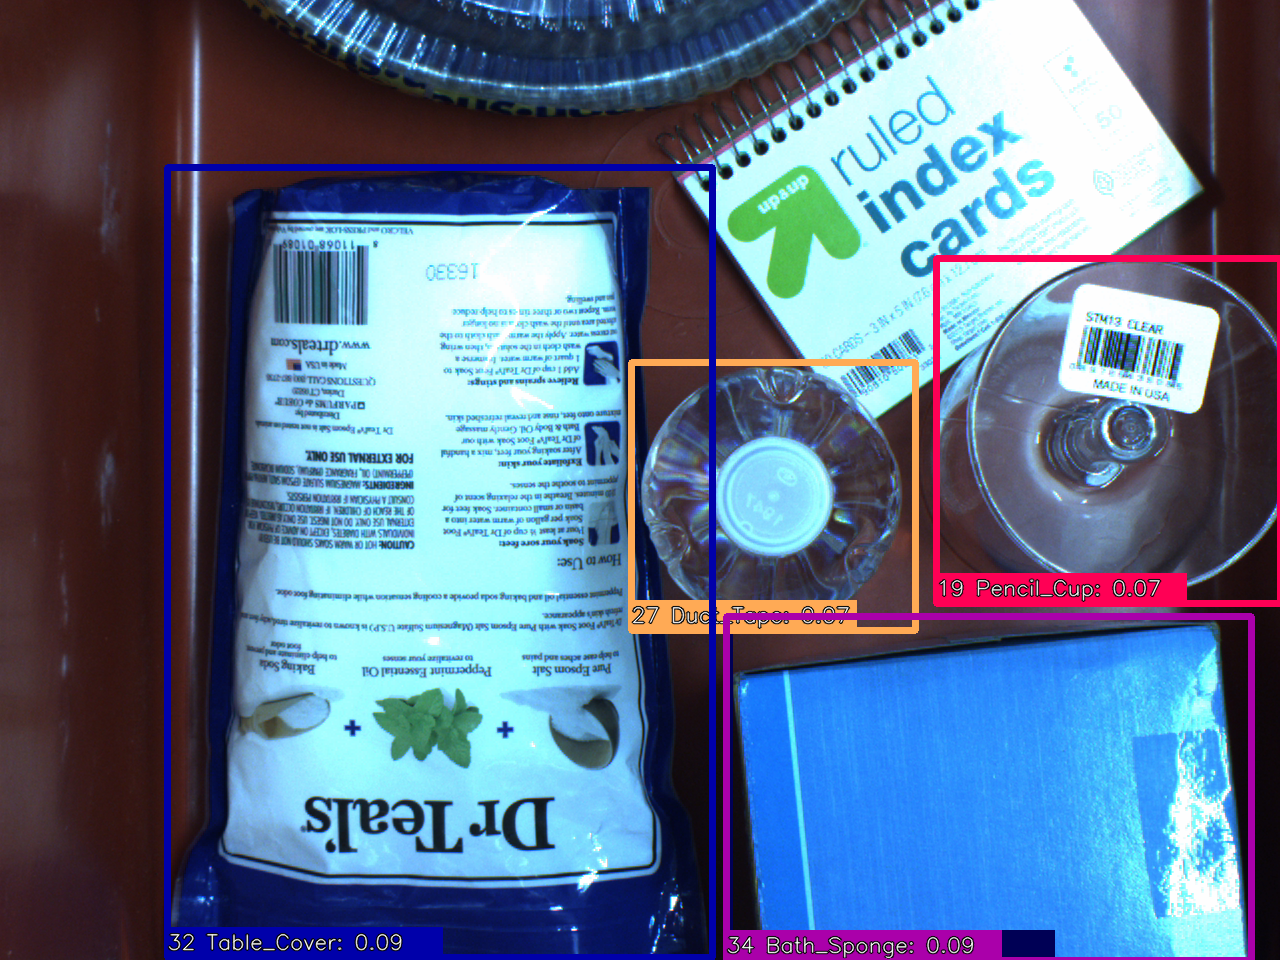

In [42]:
from IPython.display import Image,display_png
display_png(Image('out/detection/2017-016-1.png'))

次に評価を実施します．評価プログラムdetect_evaluation.pyを実行すると，検出されたバウンディングボックス1つに対して，その画像に存在するすべての教師信号のバウンディングボックスとIoUを比較して，最もIoUが高いものを探索します．見つかったボックスのクラスと検出されたボックスのクラスと2つのボックスのIoUを計算し，テキストファイルに書き出します．
次に，書き出したテキストファイルを読んでConfusion Matrixを計算します．IoUが閾値以上かつクラスが合っていれば検出成功，そうでなければ検出失敗とします．計算が終了すると，画像形式のConfusion Matrixと，次の3つの値を出力します．
- 識別率: 検出された物体のうち，クラスが正しかった割合
- 未検出率: 全ての物体のうち，検出できなかった割合
- 平均IoU: 全てのバウンディングボックスのIoUの平均

In [43]:
%cd detect_evaluation/ # 作業ディレクトリの移動

/content/07_SSD/detect_evaluation


In [44]:
!python detect_evaluation.py # 評価用ソフトウェアの実行

../out/detection_txt/2017-006-2res.txt
Result
Matching Success
Matching Failed
(16, 201, 427, 687, 960)0.8396799492270729
No Match
(20, 278, 201, 709, 572)
(15, 637, 336, 1027, 830)
(39, 916, 1, 1280, 712)
(3, 801, 716, 1241, 960)
File output
../out/detection_txt/2017-366-1res.txt
Result
Matching Success
Matching Failed
(1, 248, 4, 1266, 323)0.6817640047675805
(34, 808, 217, 1275, 738)0.9517309085809121
No Match
(3, 123, 293, 764, 855)
(37, 98, 488, 1280, 960)
(4, 140, 1, 1229, 934)
(17, 439, 224, 550, 372)
(18, 227, 327, 442, 446)
(12, 509, 138, 1197, 344)
File output
../out/detection_txt/2017-096-2res.txt
Result
Matching Success
(19, 267, 65, 709, 494)
Matching Failed
(1, 222, 777, 920, 960)0.9648506151142355
(4, 92, 81, 280, 860)0.9510467740680209
(16, 265, 64, 710, 491)0.9641627902125618
(40, 304, 505, 582, 736)0.9491719194166358
No Match
(34, 692, 77, 1278, 591)
(23, 542, 570, 1262, 821)
(12, 992, 853, 1280, 958)
File output
../out/detection_txt/2017-211-2res.txt
Result
Matching S

Total Result以降が学習済みモデルの評価結果を表しています．
ここまでで，SSDによる物体検出ができていることを確認しました．

## ファインチューニング
SSDはネットワークモデルのサイズが大きいため，学習に時間を必要とします．そのため今回の実験では，ファインチューニングの実験を1epochとして行うものとします．

## 課題
1. エポック数を変えて実験し，検出精度の変化を確認しましょう．

In [ ]:
#ここにコードを書く

## 参考文献
 - [1] R. Araki, T. Onishi, T. Hirakawa, T. Yamashita and H. Fujiyoshi, "MT-DSSD: Deconvolutional Single Shot Detector Using Multi Task Learning for Object Detection". In 2020 IEEE International Conference on Robotics and Automation, pp. 10487-10493, 2020.
 - [2] Wei Liu, Dragomir Anguelov, Dumitru Erhan , Christian Szegedy, Scott E. Reed, Cheng-Yang Fu and Alexander C. Berg, "SSD: Single Shot MultiBox Detector". In 2016 European Conference on Computer Vision, pp. 21-37, 2016.